# ***Documentation in progress***

LightGBM does not grow a tree level-wise — row by row — as most other implementations do.[9] Instead it grows trees leaf-wise. It will choose the leaf with max delta loss to grow

Handles Non-linearity: Captures complex patterns in price/volume data

Automatic Feature Selection: Ignores irrelevant technical indicators

Efficient with Time-Series: Processes temporal data faster than RNNs/LSTMs

Robust to Overfitting: Built-in regularization (unlike plain Linear Regression)

LightGBM is a tree-based machine learning algorithm that uses:

Gradient Boosting Framework: Builds trees sequentially, where each new tree corrects errors from previous ones

Decision Trees: But with two key innovations (more below)

Developed by Microsoft, it's optimized for speed and memory efficiency compared to XGBoost or Random Forests.

2. Key Innovations
Feature	How It Works	Benefit for Stock Prediction
Leaf-wise Growth	Expands the leaf that reduces loss the most (vs. level-wise)	Better accuracy with fewer trees
Histogram-based	Bins continuous features into discrete values	Faster training & handles noise better
GOSS (Gradient-based One-Side Sampling)	Keeps data points with large gradients	Focuses on hard-to-predict price movements

We want to calculate the percentage return

In [121]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb  # Add this import at the top of your notebook/script
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [122]:
# 1. Prompt user for stock ticker
ticker = input("Enter stock ticker (e.g. AAPL, MSFT, TSLA): ").upper()


Enter stock ticker (e.g. AAPL, MSFT, TSLA): tsla


In [123]:
print(f"\nDownloading {ticker} data...")
df = yf.download(ticker, start='2005-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'))

[*********************100%***********************]  1 of 1 completed


In [124]:
# Flatten MultiIndex columns (if they exist)
# Standardize column names (force lowercase + append ticker)
df.columns = [f"{col[0].lower()}_{ticker.lower()}" if isinstance(df.columns, pd.MultiIndex)
             else f"{col.lower()}_{ticker.lower()}"
             for col in df.columns]

In [125]:
# Calculate actual returns (avoiding lookahead bias)
# df['actual_return'] = df[close_col].pct_change().shift(-1)  # Next day's return

In [126]:
df

,close_tsla,high_tsla,low_tsla,open_tsla,volume_tsla
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500
...,...,...,...,...,...
2025-03-28,263.549988,276.100006,260.570007,275.579987,123809400
2025-03-31,259.160004,260.559998,243.360001,249.309998,134008900
2025-04-01,268.459991,277.450012,259.250000,263.799988,146486900


add returns

In [127]:
# Calculate returns BEFORE slicing
df['Actual_Return'] = df[f'close_{ticker.lower()}'].pct_change()
df = df.dropna()  # Remove rows with missing target


In [128]:
actual_data = df.iloc[-5:].copy()

In [129]:
actual_data

,close_tsla,high_tsla,low_tsla,open_tsla,volume_tsla,Actual_Return
Date,,,,,,
2025-03-28,263.549988,276.100006,260.570007,275.579987,123809400,-0.035075
2025-03-31,259.160004,260.559998,243.360001,249.309998,134008900,-0.016657
2025-04-01,268.459991,277.450012,259.250000,263.799988,146486900,0.035885
2025-04-02,282.760010,284.989990,251.270004,254.600006,212787800,0.053267
2025-04-03,267.279999,276.299988,261.510010,265.290009,136174300,-0.054746


remove the latest 5 so we can predict this week's and compare later on

In [130]:
# Define the close column name (works for any ticker)
close_col = f"close_{ticker.lower()}"  # e.g., "close_aapl"
close_col

'close_tsla'

In [131]:
# Calculate 5-day returns (using the standardized name)
df['5_day_return'] = df[close_col].pct_change(5).shift(-5)
df.dropna(inplace=True)

<ipython-input-131-27e99872495e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['5_day_return'] = df[close_col].pct_change(5).shift(-5)
<ipython-input-131-27e99872495e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [132]:
df

,close_tsla,high_tsla,low_tsla,open_tsla,volume_tsla,Actual_Return,5_day_return
Date,,,,,,,
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500,-0.002511,-0.267310
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000,-0.078473,-0.207650
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000,-0.125683,-0.111979
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500,-0.160937,0.126008
2010-07-07,1.053333,1.108667,0.998667,1.093333,103825500,-0.019243,0.255697
...,...,...,...,...,...,...,...
2025-03-21,248.710007,249.520004,234.550003,234.990005,132728700,0.052696,0.059668
2025-03-24,278.390015,278.640015,256.329987,258.079987,169079900,0.119336,-0.069076
2025-03-25,288.140015,288.200012,271.279999,283.600006,150361500,0.035023,-0.068300


In [133]:
#numbpy version
import numpy as np
np.__version__
!pip install pandas_ta  # No compilation needed
!pip install numpy==1.24.0  # Downgrade to last stable v1.x

In [134]:
import pandas_ta as ta


In [135]:
# Lagged returns (using close_col)
for lag in [1, 2, 5, 10, 20]:
    df[f'return_lag_{lag}'] = df[close_col].pct_change(lag)

# Rolling stats
df['rolling_5_mean'] = df[close_col].rolling(5).mean()
df['rolling_10_std'] = df[close_col].rolling(10).std()

# Technical indicators (e.g., RSI)
df['rsi_14'] = ta.rsi(df[close_col], length=14)  # Works just like TA-Lib

<ipython-input-135-c3df8937ef6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'return_lag_{lag}'] = df[close_col].pct_change(lag)
<ipython-input-135-c3df8937ef6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'return_lag_{lag}'] = df[close_col].pct_change(lag)
<ipython-input-135-c3df8937ef6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [136]:
# Split into features (X) and target (y)
X = df.drop(['5_day_return', 'Close', 'Adj Close'], axis=1, errors='ignore')  # Keep only features
y = df['5_day_return']

# Exclude last 5 days for final prediction & evaluation
# Split data:
# - Train on all data EXCEPT last 5 days
# - Test on last 5 days (which we pretend are "future" data)
X_train, X_test = X.iloc[:-5], X.iloc[-5:]
y_train, y_test = y.iloc[:-5], y.iloc[-5:]

# Train-validation split (for early evaluation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [137]:

# Train LightGBM
model = LGBMRegressor()
model.fit(X_train, y_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000699
[LightGBM] [Debug] init for col-wise cost 0.000032 seconds, init for row-wise cost 0.001489 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 2963, number of used features: 14
[LightGBM] [Info] Start training from score 0.012630
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Tr

LGBMRegressor()

Check Predictions vs. Actual Returns (Last 5 Days)


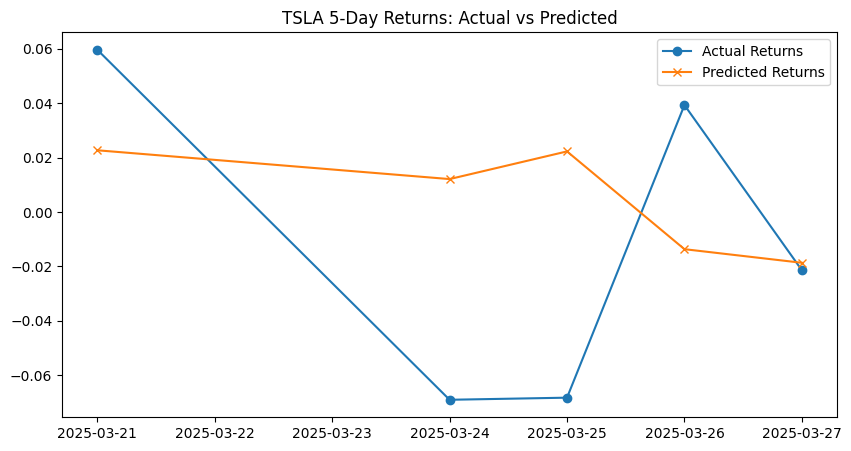

In [138]:
import matplotlib.pyplot as plt

# Predict on test set (last 5 days)
predicted_returns = model.predict(X_test)
actual_returns = y_test

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(X_test.index, actual_returns, label='Actual Returns', marker='o')
plt.plot(X_test.index, predicted_returns, label='Predicted Returns', marker='x')
plt.title(f"{ticker} 5-Day Returns: Actual vs Predicted")
plt.legend()
plt.show()

In [139]:
# Predict returns for the last 5 days (excluded from training)
predicted_returns = model.predict(X_test)

# Compare with actual returns
results = pd.DataFrame({
    'Date': X_test.index,
    'Actual_Return': y_test,
    'Predicted_Return': predicted_returns
})

print("Predicted vs Actual 5-Day Returns:")
print(results)

Predicted vs Actual 5-Day Returns:
                 Date  Actual_Return  Predicted_Return
Date                                                  
2025-03-21 2025-03-21       0.059668          0.022699
2025-03-24 2025-03-24      -0.069076          0.012107
2025-03-25 2025-03-25      -0.068300          0.022285
2025-03-26 2025-03-26       0.039330         -0.013681
2025-03-27 2025-03-27      -0.021418         -0.018682


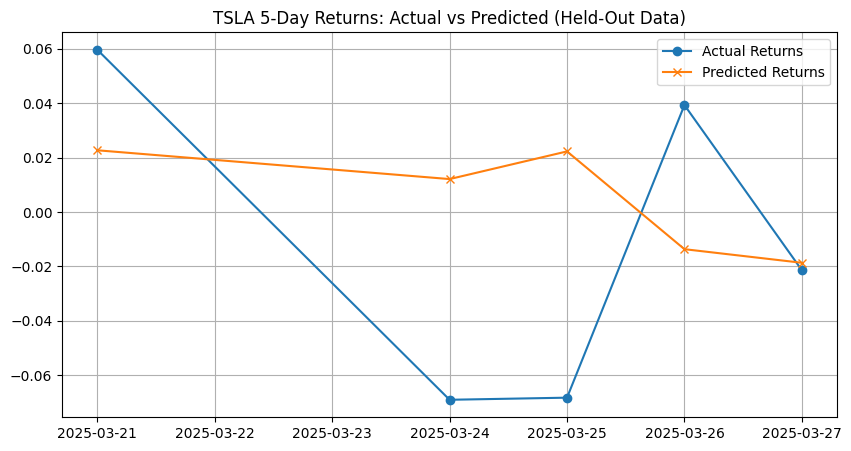

In [140]:
plt.figure(figsize=(10, 5))
plt.plot(results['Date'], results['Actual_Return'], label='Actual Returns', marker='o')
plt.plot(results['Date'], results['Predicted_Return'], label='Predicted Returns', marker='x')
plt.title(f"{ticker} 5-Day Returns: Actual vs Predicted (Held-Out Data)")
plt.legend()
plt.grid()
plt.show()

Calculate Metrics


In [141]:
# # !pip install --upgrade scikit-learn
# import sklearn
# print(sklearn.__version__)


In [142]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual_returns, predicted_returns)
# rmse = mean_squared_error(actual_returns, predicted_returns)
#rms = sqrt of mse
rmse = np.sqrt(mean_squared_error(actual_returns, predicted_returns))

print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f}")

MAE: 0.0529 | RMSE: 0.0616


Action: Focus on top features (e.g., rsi_14, return_lag_5). Remove low-importance features to reduce overfitting



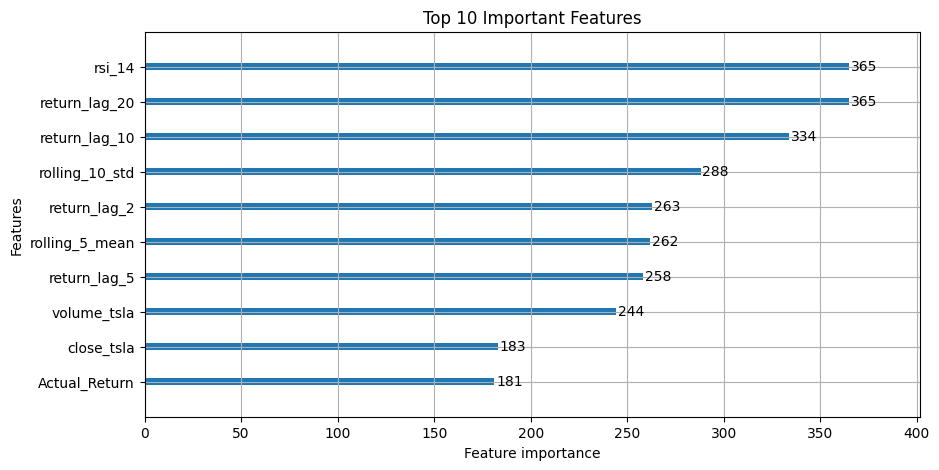

In [143]:
# Plot feature importance
# Plot feature importance
lgb.plot_importance(model, max_num_features=10, figsize=(10, 5))
plt.title("Top 10 Important Features")
plt.show()

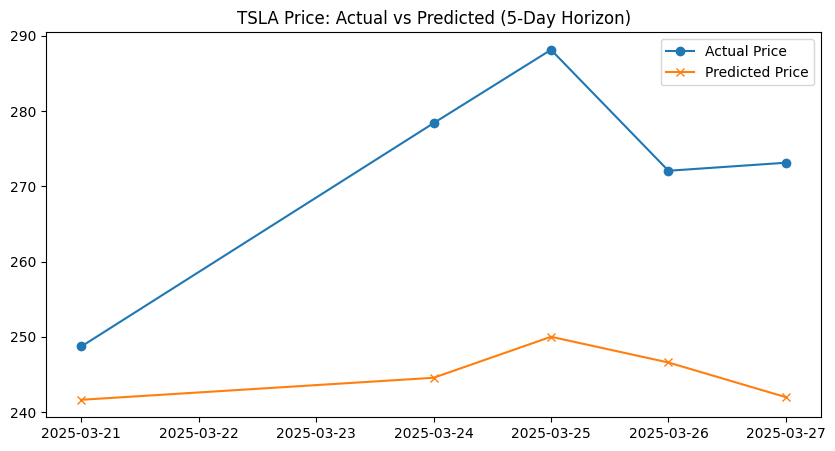

In [144]:
# Get last known price before the test window
last_price = df[close_col].iloc[-6]  # Price 5 days before X_test

# Convert predicted returns to prices
predicted_prices = last_price * (1 + predicted_returns).cumprod()
actual_prices = df[close_col].iloc[-5:]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(X_test.index, actual_prices, label='Actual Price', marker='o')
plt.plot(X_test.index, predicted_prices, label='Predicted Price', marker='x')
plt.title(f"{ticker} Price: Actual vs Predicted (5-Day Horizon)")
plt.legend()
plt.show()

In [145]:
# Train on ALL data (no test split)
X_train = df.drop(['5_day_return', close_col], axis=1, errors='ignore')
y_train = df['5_day_return']
model.fit(X_train, y_train)  # Retrain on full dataset

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000643
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.000781 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 3709, number of used features: 13
[LightGBM] [Info] Start training from score 0.010566
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Tra

LGBMRegressor()

In [146]:
# Get the last 5 rows to compute future features
last_window = df.iloc[-5:].copy()


In [147]:
last_window

,close_tsla,high_tsla,low_tsla,open_tsla,volume_tsla,Actual_Return,5_day_return,return_lag_1,return_lag_2,return_lag_5,return_lag_10,return_lag_20,rolling_5_mean,rolling_10_std,rsi_14
Date,,,,,,,,,,,,,,,
2025-03-21,248.710007,249.520004,234.550003,234.990005,132728700,0.052696,0.059668,0.052696,0.054481,-0.005080,-0.053147,-0.263736,236.829999,9.662227,39.371380
2025-03-24,278.390015,278.640015,256.329987,258.079987,169079900,0.119336,-0.069076,0.119336,0.178321,0.169657,0.253162,-0.157747,244.906003,14.731744,49.599717
2025-03-25,288.140015,288.200012,271.279999,283.600006,150361500,0.035023,-0.068300,0.035023,0.158538,0.278860,0.249631,-0.048415,257.472006,19.674406,52.438352
2025-03-26,272.059998,284.899994,266.510010,282.660004,153629800,-0.055806,0.039330,-0.055806,-0.022738,0.153481,0.096618,-0.064443,264.712006,20.976050,47.669801
2025-03-27,273.130005,291.850006,271.820007,272.480011,162572100,0.003933,-0.021418,0.003933,-0.052093,0.156057,0.134826,-0.031282,272.086008,21.643116,48.008609


In [148]:
# # Example: Compute features for the next 5 days
# # (Assuming no future data is available, we approximate)
# future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=5, freq='B')  # Business days

# # Initialize a DataFrame for future predictions
# future_data = pd.DataFrame(index=future_dates)

# # Propagate features forward (simplified approximation)
# for col in X_train.columns:
#     if 'lag' in col:
#         # Lagged returns: Use most recent available
#         future_data[col] = last_window[col].iloc[-1]
#     elif 'rolling' in col:
#         # Rolling stats: Extend last window's values
#         future_data[col] = last_window[col].iloc[-1]
#     elif 'rsi' in col or 'macd' in col:
#         # Technical indicators: Recompute if possible (or carry forward)
#         future_data[col] = last_window[col].iloc[-1]

# # Ensure all columns match training data
# future_data = future_data[X_train.columns]

In [149]:
# Get the last 5 days of data (all features pre-computed)
future_data = df.iloc[-5:].copy()

In [150]:
future_data

,close_tsla,high_tsla,low_tsla,open_tsla,volume_tsla,Actual_Return,5_day_return,return_lag_1,return_lag_2,return_lag_5,return_lag_10,return_lag_20,rolling_5_mean,rolling_10_std,rsi_14
Date,,,,,,,,,,,,,,,
2025-03-21,248.710007,249.520004,234.550003,234.990005,132728700,0.052696,0.059668,0.052696,0.054481,-0.005080,-0.053147,-0.263736,236.829999,9.662227,39.371380
2025-03-24,278.390015,278.640015,256.329987,258.079987,169079900,0.119336,-0.069076,0.119336,0.178321,0.169657,0.253162,-0.157747,244.906003,14.731744,49.599717
2025-03-25,288.140015,288.200012,271.279999,283.600006,150361500,0.035023,-0.068300,0.035023,0.158538,0.278860,0.249631,-0.048415,257.472006,19.674406,52.438352
2025-03-26,272.059998,284.899994,266.510010,282.660004,153629800,-0.055806,0.039330,-0.055806,-0.022738,0.153481,0.096618,-0.064443,264.712006,20.976050,47.669801
2025-03-27,273.130005,291.850006,271.820007,272.480011,162572100,0.003933,-0.021418,0.003933,-0.052093,0.156057,0.134826,-0.031282,272.086008,21.643116,48.008609


In [151]:
# Set dates to the next 5 trading days
last_date = df.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=5,
    freq='B'  # Business days only
)
future_data.index = future_dates  # Update dates

# Drop the target column ('5_day_return') if it exists
future_data = future_data.drop(columns=['5_day_return'], errors='ignore')

Ensure Feature Columns Match Training Data


In [152]:
# Keep only the columns used in training
future_data = future_data[X_train.columns]

In [153]:
future_data


,high_tsla,low_tsla,open_tsla,volume_tsla,Actual_Return,return_lag_1,return_lag_2,return_lag_5,return_lag_10,return_lag_20,rolling_5_mean,rolling_10_std,rsi_14
2025-03-28,249.520004,234.550003,234.990005,132728700,0.052696,0.052696,0.054481,-0.005080,-0.053147,-0.263736,236.829999,9.662227,39.371380
2025-03-31,278.640015,256.329987,258.079987,169079900,0.119336,0.119336,0.178321,0.169657,0.253162,-0.157747,244.906003,14.731744,49.599717
2025-04-01,288.200012,271.279999,283.600006,150361500,0.035023,0.035023,0.158538,0.278860,0.249631,-0.048415,257.472006,19.674406,52.438352
2025-04-02,284.899994,266.510010,282.660004,153629800,-0.055806,-0.055806,-0.022738,0.153481,0.096618,-0.064443,264.712006,20.976050,47.669801
2025-04-03,291.850006,271.820007,272.480011,162572100,0.003933,0.003933,-0.052093,0.156057,0.134826,-0.031282,272.086008,21.643116,48.008609


Predict Returns for the Next 5 Days


In [154]:
predicted_returns = model.predict(future_data)
predicted_prices = df[close_col].iloc[-1] * (1 + predicted_returns).cumprod()

# Format results
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Return': predicted_returns,
    'Predicted_Price': predicted_prices
})

print("Predicted Next 5 Trading Days:")
print(future_predictions)

Predicted Next 5 Trading Days:
        Date  Predicted_Return  Predicted_Price
0 2025-03-28          0.068869       291.940090
1 2025-03-31         -0.026765       284.126322
2 2025-04-01         -0.040987       272.480708
3 2025-04-02          0.007485       274.520243
4 2025-04-03          0.006047       276.180359


filter out weekends if any

In [155]:
df['rolling_5_mean'] = df[close_col].shift(1).rolling(5).mean()  # Lagged by 1 day

<ipython-input-155-e9170ad976eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_5_mean'] = df[close_col].shift(1).rolling(5).mean()  # Lagged by 1 day


In [156]:
# 1. Lagged returns (multiple windows) - Same as before (pandas native)
for lag in [1, 2, 5, 10, 20]:
    df[f'return_lag_{lag}'] = df[close_col].pct_change(lag)

# 2. Volatility metrics - Same as before (pandas native)
df['volatility_10'] = df[close_col].pct_change().rolling(10).std()

# 3. Volume trends - Same as before (pandas native)
df['volume_ma_5'] = df[f'volume_{ticker.lower()}'].rolling(5).mean()

# 4. Relative Strength Index (RSI) - pandas_ta version
df['rsi_14'] = ta.rsi(df[close_col], length=14)

# 5. MACD (Trend-following momentum) - pandas_ta version
macd = ta.macd(df[close_col], fast=12, slow=26, signal=9)
df['macd'] = macd['MACD_12_26_9']  # Just the MACD line
# If you want all components:
# df['macd_line'] = macd['MACD_12_26_9']
# df['macd_signal'] = macd['MACDs_12_26_9']
# df['macd_hist'] = macd['MACDh_12_26_9']

# 6. Bollinger Bands - pandas_ta version
bbands = ta.bbands(df[close_col], length=20)
df['upper_band'] = bbands['BBU_20_2.0']
df['middle_band'] = bbands['BBM_20_2.0']
df['lower_band'] = bbands['BBL_20_2.0']

<ipython-input-156-87fcf2a0acd1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'return_lag_{lag}'] = df[close_col].pct_change(lag)
<ipython-input-156-87fcf2a0acd1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['volatility_10'] = df[close_col].pct_change().rolling(10).std()
<ipython-input-156-87fcf2a0acd1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

Drop Low-Impact Features


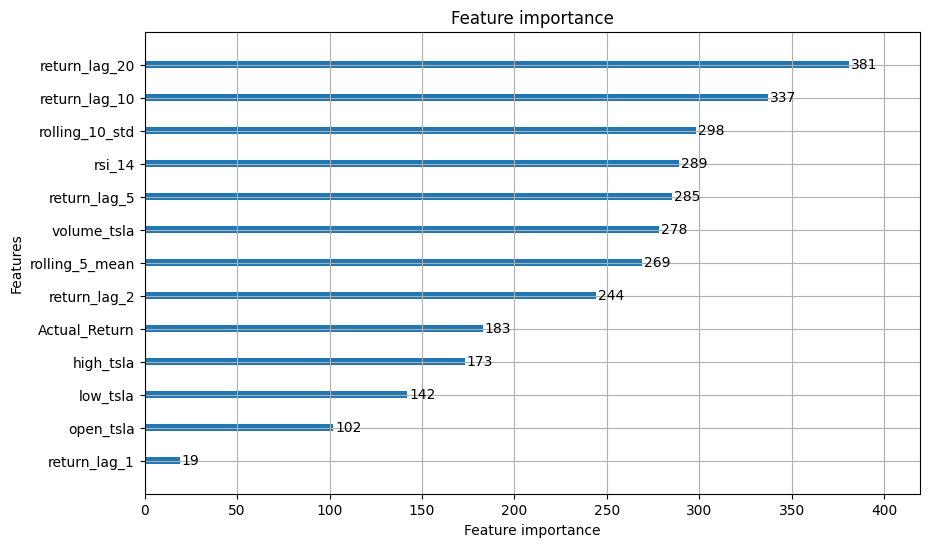

In [157]:
# Plot feature importance
import lightgbm as lgb
lgb.plot_importance(model, max_num_features=20, figsize=(10, 6))
plt.show()
# Remove features with low importance

In [158]:
# Drop columns dynamically based on the ticker
cols_to_drop = [f'open_{ticker.lower()}', f'low_{ticker.lower()}', f'high_{ticker.lower()}']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')  # 'errors=ignore' skips missing columns
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

In [159]:
# df.columns

In [160]:
# Interaction between lagged returns and volatility
df['lag20_vol_interaction'] = df['return_lag_20'] * df['rolling_10_std']

# Interaction between volume and lagged returns
# df['volume_lag20_interaction'] = df['volume_aapl'] * df['return_lag_20']
df[f'volume_lag20_interaction'] = df[f'volume_{ticker.lower()}'] * df[f'return_lag_20']


<ipython-input-160-e05d6d040f6c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag20_vol_interaction'] = df['return_lag_20'] * df['rolling_10_std']
<ipython-input-160-e05d6d040f6c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'volume_lag20_interaction'] = df[f'volume_{ticker.lower()}'] * df[f'return_lag_20']


In [161]:
# Rolling volatility of returns (not just price)
df['rolling_10_return_std'] = df['return_lag_1'].rolling(10).std()

# Volume spikes (e.g., z-score)
# df['volume_zscore'] = (df['volume_aapl'] - df['volume_aapl'].rolling(20).mean()) / df['volume_aapl'].rolling(20).std()
df[f'volume_zscore'] = (
    (df[f'volume_{ticker.lower()}'] - df[f'volume_{ticker.lower()}'].rolling(20).mean()) /
    df[f'volume_{ticker.lower()}'].rolling(20).std()
)

<ipython-input-161-eb3a1172f9fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_10_return_std'] = df['return_lag_1'].rolling(10).std()
<ipython-input-161-eb3a1172f9fc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'volume_zscore'] = (


In [162]:
# Lagged volume changes
for lag in [1, 2, 5]:
    df[f'volume_change_lag_{lag}'] = df[f'volume_{ticker.lower()}'].pct_change(lag)

<ipython-input-162-f2c3efd7a9ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'volume_change_lag_{lag}'] = df[f'volume_{ticker.lower()}'].pct_change(lag)
<ipython-input-162-f2c3efd7a9ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'volume_change_lag_{lag}'] = df[f'volume_{ticker.lower()}'].pct_change(lag)
<ipython-input-162-f2c3efd7a9ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [163]:
# Binary target: 1 if return > 90th percentile, else 0
df['target_high_return'] = (df['5_day_return'] > df['5_day_return'].quantile(0.9)).astype(int)

<ipython-input-163-d0c3611380cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target_high_return'] = (df['5_day_return'] > df['5_day_return'].quantile(0.9)).astype(int)


In [164]:
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    min_child_samples=20,
    feature_fraction=0.8,  # Force model to use top features more
    verbose=10
)

Solution: Dynamic Top Feature Selection


In [165]:
# First training (all features)
full_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    min_child_samples=20,
    feature_fraction=0.8,
    verbose=10
)
full_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000836
[LightGBM] [Debug] init for col-wise cost 0.000014 seconds, init for row-wise cost 0.000486 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3709, number of used features: 10
[LightGBM] [Info] Start training from score 0.010566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] 

LGBMRegressor(feature_fraction=0.8, learning_rate=0.01, max_depth=5,
              n_estimators=500, verbose=10)

In [166]:
# Get initial importances
full_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': full_model.feature_importances_
}).sort_values('importance', ascending=False)

# Select top 3 features
top_features = full_importance_df.head(3)['feature'].tolist()
top_features

['rolling_5_mean', 'return_lag_20', 'rolling_10_std']

In [167]:
full_importance_df

,feature,importance
7,rolling_5_mean,1709
6,return_lag_20,1271
8,rolling_10_std,1093
5,return_lag_10,1036
9,rsi_14,676
0,volume_tsla,662
4,return_lag_5,577
3,return_lag_2,511
1,Actual_Return,362
2,return_lag_1,143


In [168]:
# Second training (top features only)
top_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    min_child_samples=20,
    feature_fraction=0.8,
    verbose=10
)
top_model.fit(X_train[top_features], y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000090
[LightGBM] [Debug] init for col-wise cost 0.000004 seconds, init for row-wise cost 0.000166 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 3709, number of used features: 3
[LightGBM] [Info] Start training from score 0.010566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Tr

LGBMRegressor(feature_fraction=0.8, learning_rate=0.01, max_depth=5,
              n_estimators=500, verbose=10)

In [169]:
# Get new importances (will only show top 3)
top_importance_df = pd.DataFrame({
    'feature': top_features,
    'importance': top_model.feature_importances_
}).sort_values('importance', ascending=False)

# Compare results
print("Full Model Feature Importances:")
print(full_importance_df)
print("\nTop Features Model Importances:")
print(top_importance_df)

# # Plot importance for verification
# lgb.plot_importance(model, max_num_features=20, figsize=(10, 6))
# plt.show()

Full Model Feature Importances:
          feature  importance
7  rolling_5_mean        1709
6   return_lag_20        1271
8  rolling_10_std        1093
5   return_lag_10        1036
9          rsi_14         676
0     volume_tsla         662
4    return_lag_5         577
3    return_lag_2         511
1   Actual_Return         362
2    return_lag_1         143

Top Features Model Importances:
          feature  importance
1   return_lag_20        4024
2  rolling_10_std        3198
0  rolling_5_mean        1715


rolling_10
volume_appl
return_lag_20

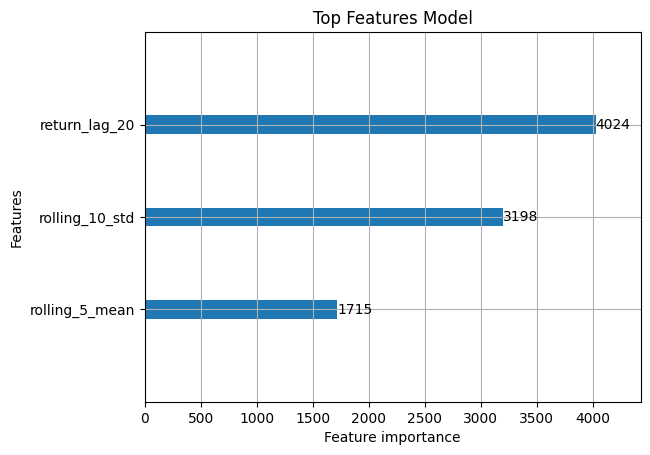

In [170]:
# Top features importance
lgb.plot_importance(top_model, title="Top Features Model")
plt.show()

In [171]:
# Select only the top 3 features for future_data
# future_data_top = future_data[['return_lag_20', 'rolling_10_std', 'volume_aapl']]
future_data_top = future_data[top_features]

# Verify shapes match training data
# print(f"Shape check: {X_train_top.shape[1]} features vs {future_data_top.shape[1]}")  # Should both be 3

In [172]:
# Predict using the top-feature-only model


# Predict using the CORRECT model (top_model, not model)
predicted_returns_top = top_model.predict(future_data_top)  # Use top_model here!

# Convert returns to price predictions
last_price = df[close_col].iloc[-1]  # Last known price
predicted_prices_top = last_price * (1 + predicted_returns_top).cumprod()

# Format results
future_predictions_top = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Return': predicted_returns_top,
    'Predicted_Price': predicted_prices_top
})

print("Predictions (Top 3 Features Only):")
print(future_predictions_top)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Predictions (Top 3 Features Only):
        Date  Predicted_Return  Predicted_Price
0 2025-03-28          0.043074       284.894796
1 2025-03-31         -0.021541       278.757923
2 2025-04-01         -0.021141       272.864809
3 2025-04-02         -0.028032       265.215970
4 2025-04-03          0.011303       268.213797


In [173]:
# Convert actual_data index to datetime if needed
actual_data.index = pd.to_datetime(actual_data.index)

# Merge predictions with actuals using dynamic ticker name
# comparison = pd.merge(
#     future_predictions_top.set_index('Date'),
#     actual_data[[f'close_{ticker.lower()}']],  # Dynamic column name
#     left_index=True,
#     right_index=True,
#     how='left'  # Keeps all predicted dates
# )
# 5. Merge results
# 3. Merge WITHOUT recalculating
comparison = pd.merge(
    future_predictions_top.set_index('Date'),
    actual_data[[f'close_{ticker.lower()}', 'Actual_Return']],
    left_index=True,
    right_index=True,
    how='left'
).rename(columns={
    f'close_{ticker.lower()}': 'Actual_Price'
})

# Rename columns for clarity - use dynamic ticker name
comparison = comparison.rename(columns={
    f'close_{ticker.lower()}': 'Actual_Price',  # Fixed here
    'Predicted_Price': 'Predicted_Price',
    'Predicted_Return': 'Predicted_Return'
})

# Calculate actual returns (optional)
# comparison['Actual_Return'] = comparison['Actual_Price'].pct_change()
# This is actually correct - first return should be NaN

# If you want to fill NaN with 0 (less accurate)
# comparison['Actual_Return'] = comparison['Actual_Return'].fillna(0)
# Display the comparison
comparison

,Predicted_Return,Predicted_Price,Actual_Price,Actual_Return
Date,,,,
2025-03-28,0.043074,284.894796,263.549988,-0.035075
2025-03-31,-0.021541,278.757923,259.160004,-0.016657
2025-04-01,-0.021141,272.864809,268.459991,0.035885
2025-04-02,-0.028032,265.215970,282.760010,0.053267
2025-04-03,0.011303,268.213797,267.279999,-0.054746


MAPE evaluates price-level accuracy (lower = better)

Mean Absolute Percentage Error

In [174]:
from sklearn.metrics import mean_absolute_percentage_error

# - comparison['Actual_Price'] (true prices)
# - comparison['Predicted_Price'] (model predictions)

mape = mean_absolute_percentage_error(comparison['Actual_Price'],
                                     comparison['Predicted_Price']) * 100  # Convert to %
print(f"MAPE: {mape:.2f}%")

MAPE: 4.77%



Directional Accuracy shows if you're correctly predicting ups/downs (higher = better).




In [175]:
# First ensure both series have matching indices
valid_mask = comparison['Actual_Return'].notna() & comparison['Predicted_Return'].notna()
actual_directions = np.sign(comparison.loc[valid_mask, 'Actual_Return'])
predicted_directions = np.sign(comparison.loc[valid_mask, 'Predicted_Return'])

# Now calculate accuracy
direction_accuracy = np.mean(actual_directions == predicted_directions) * 100
print(f"Directional Accuracy: {direction_accuracy:.2f}%")

Directional Accuracy: 20.00%


For stocks, directional accuracy often matters more than absolute price error.



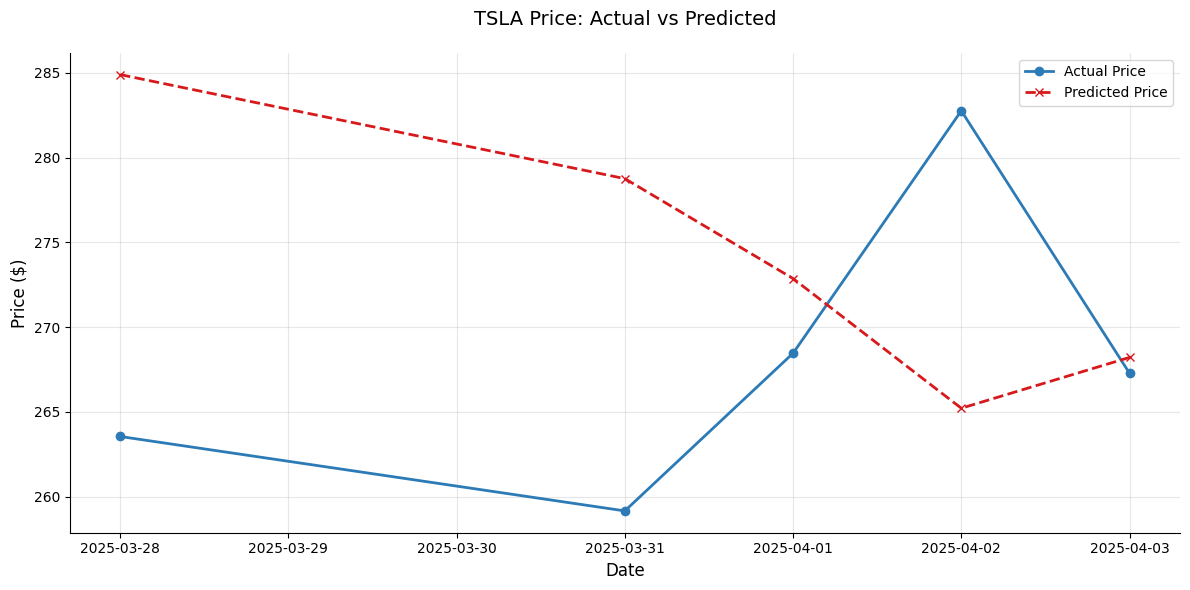

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.plot(comparison.index, comparison['Actual_Price'],
         label='Actual Price', marker='o', linewidth=2, color='#2c7bb6')
plt.plot(comparison.index, comparison['Predicted_Price'],
         label='Predicted Price', linestyle='--', marker='x', linewidth=2, color='#d7191c')
plt.title(f'{ticker.upper()} Price: Actual vs Predicted', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

In [177]:
# # Create direction matrix
# direction_df = comparison[['Predicted_Return', 'Actual_Return']].copy()
# direction_df['Predicted_Direction'] = np.sign(direction_df['Predicted_Return'])
# direction_df['Actual_Direction'] = np.sign(direction_df['Actual_Return'])

# # Plot
# plt.figure(figsize=(8, 4))
# sns.heatmap(pd.crosstab(direction_df['Predicted_Direction'],
#                        direction_df['Actual_Direction'],
#                        rownames=['Predicted'],
#                        colnames=['Actual']),
#             annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Return Direction Confusion Matrix', pad=15)
# plt.show()

In [178]:
def color_returns(val):
    color = 'red' if val < 0 else 'green'
    return f'color: {color}'

styled_table = comparison.style \
    .format({'Predicted_Price': '{:.2f}',
             'Actual_Price': '{:.2f}',
             'Predicted_Return': '{:.2%}',
             'Actual_Return': '{:.2%}'}) \
    .applymap(color_returns, subset=['Predicted_Return', 'Actual_Return']) \
    .set_caption(f'{ticker.upper()} Prediction Results') \
    .background_gradient(cmap='Blues', subset=['Actual_Price', 'Predicted_Price'])

display(styled_table)

<ipython-input-178-a2e860b1312a>:10: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_returns, subset=['Predicted_Return', 'Actual_Return']) \


,Predicted_Return,Predicted_Price,Actual_Price,Actual_Return
Date,,,,
2025-03-28 00:00:00,4.31%,284.89,263.55,-3.51%
2025-03-31 00:00:00,-2.15%,278.76,259.16,-1.67%
2025-04-01 00:00:00,-2.11%,272.86,268.46,3.59%
2025-04-02 00:00:00,-2.80%,265.22,282.76,5.33%
2025-04-03 00:00:00,1.13%,268.21,267.28,-5.47%


export to tableau

In [179]:
# Reset index to make Date a column (Tableau prefers this)
export_df = comparison.reset_index()

# Rename columns for clarity in Tableau
export_df = export_df.rename(columns={
    'Date': 'date',
    'Predicted_Price': 'predicted_price',
    'Actual_Price': 'actual_price',
    'Predicted_Return': 'predicted_return_pct',
    'Actual_Return': 'actual_return_pct'
})

# Convert percentages to decimal (optional)
export_df[['predicted_return_pct', 'actual_return_pct']] *= 100

# Save to CSV (Tableau's easiest import format)
export_df.to_csv('stock_predictions.csv', index=False)